# Spherical ICET

In [1]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp

physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
    
%load_ext autoreload
%autoreload 2
%autosave 180
# %matplotlib notebook

Autosaving every 180 seconds


In [2]:
from ICET_spherical import ICET

# init KITTI dataset -----------------------------------------------------------------
basedir = 'C:/kitti/'
date = '2011_09_26'
drive = '0005'
idx = 0
# drive = '0093'
# idx = 220
dataset = pykitti.raw(basedir, date, drive)
velo1 = dataset.get_velo(idx) # Each scan is a Nx4 array of [x,y,z,reflectance]
c1 = velo1[:,:3]
velo2 = dataset.get_velo(idx+1) # Each scan is a Nx4 array of [x,y,z,reflectance]
c2 = velo2[:,:3]
# c1 = c1[c1[:,2] > -1.5] #ignore ground plane
# c2 = c2[c2[:,2] > -1.5] #ignore ground plane
# ------------------------------------------------------------------------------------

# # ## load custom point cloud geneated in matlab------------------------------------------
# c1 = np.loadtxt("verify_geometry_scan1.txt", dtype = float) #for debugging DNN filter
# c2 = np.loadtxt("verify_geometry_scan2.txt", dtype = float)
# #debug: get rid of half of the points in scan 2 (testing outlier rejection indexing)
# # c2 = c2[c2[:,1] > 0 ]
# #add noise (if not generated when point clouds were created)
# # c1 += 0.02*np.random.randn(np.shape(c1)[0], 3)
# # c2 += 0.02*np.random.randn(np.shape(c2)[0], 3) 
# c1 = c1[c1[:,2] > -1.55] #ignore ground plane
# c2 = c2[c2[:,2] > -1.55] #ignore ground plane
# # ## ------------------------------------------------------------------------------------

# #single distinct cluster---------------------------------------------------------------
# c1 = np.random.randn(3000,3)*tf.constant([0.04,0.3,0.3]) + tf.constant([6.,0.,0.])
# c2 = np.random.randn(3000,3)*tf.constant([0.04,0.3,0.3]) + tf.constant([6.,0.,0.]) - np.array([0., 0.25, 0.0])
# # # c2 = c1 - np.array([0.1, 0.3, 0.0])
# # -------------------------------------------------------------------------------------

D = True
# D = False
X = tf.constant([0., 0., 0., 0., 0., 0.])
it1 = ICET(cloud1 = c1, cloud2 = c2,  fid = 50, draw = D, 
           x0 = X, niter = 5, group= 2, RM = False, DNN_filter = False)

ViewInteractiveWidget(it1.plt.window)

KeyboardInterrupt: 

In [ ]:
#test rejection
# print(tf.shape(it1.residuals_full))
# print(tf.shape(it1.U_i))

res = it1.residuals_full
U = it1.U_i
L = it1.L_i

res_compact = L @ tf.transpose(U, [0,2,1]) @ res[:,:,None]
# print(res_compact)
bad = tf.where(tf.math.abs(res_compact) > 0.05)
print(bad[:,0])

In [3]:
#Pre-process points from ICET to feed to DNN

#Get ragged tensor containing all points from each scan inside each sufficient voxel
in1 = it1.inside1
npts1 = it1.npts1
in2 = it1.inside2
npts2 = it1.npts2
corr = it1.corr #indices of bins that have enough points from scan1 and scan2

# print(tf.shape(in2.to_tensor()))

#get indices of rag with >= 25 elements
ncells = tf.shape(corr)[0].numpy() #num of voxels with sufficent number of points
# print(tf.gather(npts2, corr))
enough1 = tf.gather(in1, corr)
enough2 = tf.gather(in2, corr)
print(tf.shape(enough2.to_tensor())[0].numpy())
# print(npts2)
# print(corr)

#init array to store indices
idx1 = np.zeros([ncells ,25])
idx2 = np.zeros([ncells ,25])

#loop through each element of ragged tensor
for i in range(ncells):
    idx1[i,:] = tf.random.shuffle(enough1[i])[:25].numpy() #shuffle order and take first 25 elements
    idx2[i,:] = tf.random.shuffle(enough2[i])[:25].numpy() #shuffle order and take first 25 elements

idx1 = tf.cast(tf.convert_to_tensor(idx1), tf.int32)
idx2 = tf.cast(tf.convert_to_tensor(idx2), tf.int32)

# print(it1.cloud1_tensor)
from1 = tf.gather(it1.cloud1_tensor, idx1)
# from2 = tf.gather(it1.cloud2_tensor_OG, idx2)
from2 = tf.gather(it1.cloud2_tensor, idx2)
# print(from1)

x_test = tf.concat((from1, from2), axis = 1)
# np.savetxt('perspective_shift/ICET_KITTI_frame0.txt', tf.reshape(from1, [-1, 3]).numpy())
# np.savetxt('perspective_shift/ICET_KITTI_frame1.txt', tf.reshape(from2, [-1, 3]).numpy())

model = tf.keras.models.load_model("perspective_shift/KITTInet.kmod")
from_DNN = model.predict(x_test)
# print(from_DNN)
# print(np.shape(from_DNN))
print(tf.math.reduce_mean(from_DNN, axis = 0))


NameError: name 'it1' is not defined

### Identify compact directions where ICET and DNN disagree

In [4]:
#compare per cell translation estimates between ICET and DNN on converged results
dnnsoln = tf.convert_to_tensor(from_DNN)
# n = 0 #cell idx
# print(dnnsoln[n])
# print(it1.residuals[n])

# icetsoln = tf.gather(it1.residuals_full, it1.corr)
icetsoln = tf.gather(it1.residuals, it1.corr) #test

#align differences between solutions with the principal axis of ICET scan1
L = it1.L #only from "mu1_enough", "sigma1_enough" -> why it's too small rn???
U = it1.U
print(tf.shape(U))
# print(U)

# print(it1.enough1) #voxel IDs from scan1 with enough points
# print(it1.corr)    # voxel IDs from BOTH with enough points

#TODO: 
#  1) get IDX of elements that are in both enough1 and corr
#  2) use this to index U and L to get U_i and L_i
# print(it1.enough1)
both = tf.sets.intersection(it1.enough1[None,:], it1.corr[None,:]).values
ans = tf.where(it1.enough1[:,None] == both)[:,0]
# print(ans)

#project into frame of principal axis of distribution from scan1, prune extended axis
LUT = tf.matmul(L, tf.transpose(U, [0,2,1]))
it_compact = tf.matmul(LUT, icetsoln[:,:,None])
dnn_compact = tf.matmul(LUT, dnnsoln[:,:,None])
# print(it_compact)
# print(dnn_compact)

#find where the largest difference in residuals are
thresh = 0.1
#be careful- not sure what this index corresponds to (may not be voxel ID)
problem_voxels = tf.where(tf.math.abs(it_compact - dnn_compact) > thresh)[:,0]
print(problem_voxels)
problem_voxels = tf.unique(problem_voxels)[0] #get rid of repeated indices
print(problem_voxels)


#remove extended axis
# print(dnnsoln - icetsoln)


NameError: name 'from_DNN' is not defined

In [5]:
#test loading raw KITTI point clouds (not compensated for rolling shutter)
fn = "C:/kitti/2011_09_26/2011_09_26_drive_0005_raw/velodyne_points/data/0000000000.txt"

test = np.loadtxt(fn)[:,:3]
print(np.shape(test))

(122783, 3)


In [6]:
# fn1 = "C:/kitti/2011_09_26/2011_09_26_drive_0005_raw/velodyne_points/data/0000000115.txt"
fn1 = "C:/kitti/2011_09_26/2011_09_26_drive_0005_raw/velodyne_points/data/%010d.txt" %(1)
print(fn1)


C:/kitti/2011_09_26/2011_09_26_drive_0005_raw/velodyne_points/data/0000000001.txt


<IPython.core.display.Javascript object>


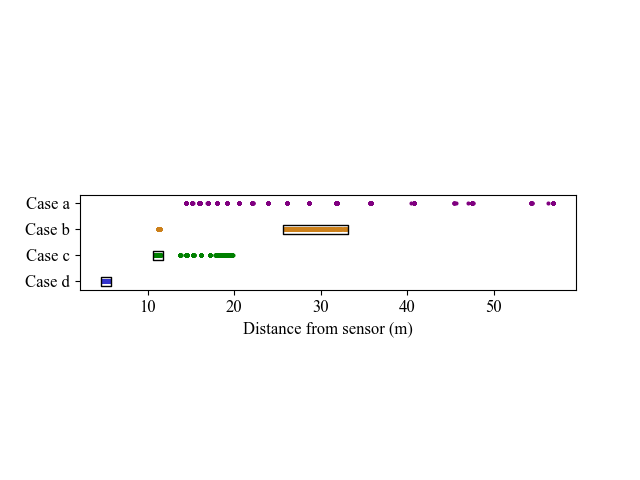

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

In [7]:
#generate plots from radial distance measurements
from matplotlib import pyplot as plt
%matplotlib notebook
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

fig, ax = plt.subplots()

purple = np.load("figure_dist_measurements2.npy")[:,0].T
green = np.load("figure_dist_measurements1.npy")[:,0].T
orange = np.load("figure_dist_measurements3.npy")[:,0].T
blue = np.load("figure_dist_measurements4.npy")[:,0].T

scale = 3

# ax.set_xlim([0,20])
ax.set_ylim([-1,3*scale + 1])
ax.set_aspect("equal")
# ax.set_yticks(ticks = [])
ax.set_yticks(labels = ['Case a', 'Case b', 'Case c', 'Case d'], ticks = [3*scale, 2*scale, 1*scale, 0.])
ax.set_xlabel("Distance from sensor (m)")
# ax.set_title("Spread of points per bin") # $\it{n}$")
# ax.set_ylabel("bin")

ptSize = 15
ax.scatter(purple, scale*3*np.ones(len(purple)), marker = '.', s = ptSize, c = [0.5,0.,0.5], label = 'a')
ax.scatter(orange, scale*2*np.ones(len(orange)), marker = '.', s = ptSize, c = [0.8,0.5,0.1], label = 'b')
ax.scatter(green, scale*1*np.ones(len(green)), marker = '.', s = ptSize, c = [0,0.5,0], label = 'c')
ax.scatter(blue, np.zeros(len(blue)), marker = '.', s = ptSize, c = [0.2,0.2,0.8], label = 'd')

patches = []
rectb = Rectangle([25.65, 5.5], 7.5, 1, fill = False) #(xy, w, h)
patches.append(rectb)
rectc = Rectangle([10.65, 2.5], 1.1, 1, fill = False) #(xy, w, h)
patches.append(rectc)
rectd = Rectangle([4.6, -0.5], 1.1, 1, fill = False) #(xy, w, h)
patches.append(rectd)

pc = PatchCollection(patches)
pc.set_edgecolor('black')
pc.set_facecolor([0,0,0,0])
ax.add_collection(pc)


# from utils import get_cluster
# test = tf.convert_to_tensor(green)[:,None]
# # print(tf.shape(test))
# bounds = get_cluster(test, mnp = 50, thresh = 0.3)
# # print("bounds:", bounds)


## Identify outlier cells

<IPython.core.display.Javascript object>


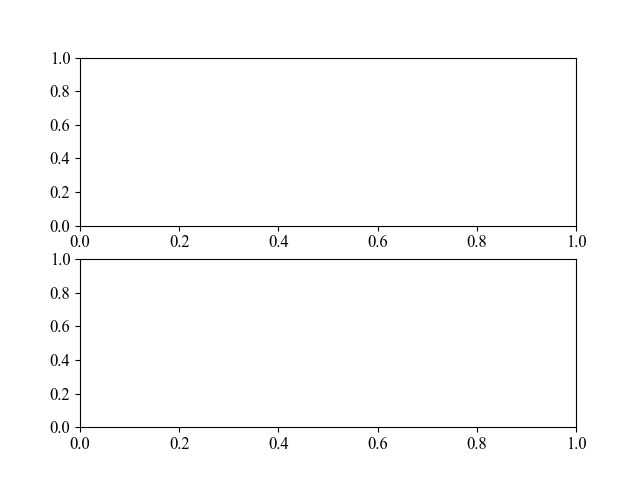

NameError: name 'it1' is not defined

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1)
nbins = 25
nstd = 2

# print(it.dx_i[:,0])
# print(tf.math.reduce_sum(it.dx_i, axis = 0))
# print(it.W)
# print(it.H)
# print(it.residuals[:,0])

component = it1.residuals_full[:,1]
print(tf.shape(component))
# print(component)

print("\n before:")
mu = tf.math.reduce_mean(component)
print("mean", mu)
sigma = tf.math.reduce_std(component)
print("standard deviation", sigma)
bad_idx = tf.where( tf.math.abs(component) > mu + nstd*sigma )
# print("bad idx", bad_idx)
good_idx = tf.where( tf.math.abs(component) < mu + nstd*sigma )
# print(tf.gather(component, bad_idx))
# ax.hist(it.dx_i[:,0], nbins);
ax[0].hist(component, nbins);
ax[0].set_xlabel("y_i - y0_i (forward translation error)")
ax[0].set_ylabel("frequency")
ax[0].set_title("All Distributions")

#test to make sure outliers are being removed correctly
component = it1.residuals[:,1]
print(tf.shape(component))
# print(component)

print("\n after:")
mu = tf.math.reduce_mean(component)
print("mean", mu)
sigma = tf.math.reduce_std(component)
print("standard deviation", sigma)

ax[1].hist(component, nbins);
ax[1].set_xlabel("y_i - y0_i (forward translation error)")
ax[1].set_ylabel("frequency")
ax[1].set_title("Best Fitting Distributions")


In [9]:
import tensorflow_probability as tfp

# print(it.residuals_full[:,0])
edges = tf.linspace(-1.,1.,30)
# print(edges)
print(edges)

bins_soln = tfp.stats.find_bins(it.residuals_full[:,0], edges)
# print(bins_soln)

good_idx = tf.where(bins_soln == 14)
bad_idx = tf.where(bins_soln == 14)
# print(bad_idx)
# print(good_idx)
# print(tf.gather(it.residuals_full[:,0], good_idx))


tf.Tensor(
[-1.         -0.9310345  -0.86206895 -0.79310346 -0.7241379  -0.6551724
 -0.5862069  -0.51724136 -0.44827586 -0.37931037 -0.31034482 -0.24137932
 -0.17241383 -0.10344827 -0.03448278  0.03448272  0.10344827  0.17241383
  0.24137926  0.31034482  0.37931037  0.4482758   0.51724136  0.5862069
  0.65517235  0.7241379   0.79310346  0.862069    0.93103445  1.        ], shape=(30,), dtype=float32)


NameError: name 'it' is not defined

In [10]:
a = tf.constant([[5, 6, 7, 8]])
b = tf.constant([[8, 7, 10]])
print(tf.sets.difference(a,b).values)

tf.Tensor([5 6], shape=(2,), dtype=int32)


## Identify Useful Clusters

In [11]:
from utils import get_cluster

#index of spike that each of the points from cloud 1 is occupying
print(it1.bins_spike)

occupied_spikes, idxs = tf.unique(it1.bins_spike)
print("\n occupied_spikes \n", occupied_spikes)
temp =  tf.where(it1.bins_spike == occupied_spikes[:,None])
rag = tf.RaggedTensor.from_value_rowids(temp[:,1], temp[:,0])
idx_by_rag = tf.gather(it1.cloud1_tensor_spherical[:,0], rag)

# rads = idx_by_rag[50,:] #single element from ragged tensor
rads = tf.transpose(idx_by_rag.to_tensor()[:3,:])
# rads = tf.transpose(idx_by_rag.to_tensor())
# print(rads) #starts out unordered

# #_________________________________________________________________
fig, ax = plt.subplots(2,1)
nbins = 25
ax[0].hist(rads.numpy(), nbins, histtype = 'step');
yax = tf.ones(tf.shape(rads), tf.float32) #plots everything on top of eachother
yax = yax * tf.cast(tf.linspace(1, 0, tf.shape(rads)[1]), tf.float32)
# print(tf.linspace(0, 1, tf.shape(rads)[1])[:,None] )
ax[1].plot(rads,yax, 'b.', markersize = 3)
# #_________________________________________________________________
""
bounds = get_cluster(rads)
print("\n Bounds \n", bounds)


NameError: name 'it1' is not defined

In [12]:
a = np.zeros([1,2])
b = np.ones([3,2])
print(np.append(b, a, axis = 0))

[[1. 1.]
 [1. 1.]
 [1. 1.]
 [0. 0.]]


In [13]:
edges_r = bounds[6,:]
print(edges_r)
pts = tf.cast(tf.convert_to_tensor(c1[:,1]), tf.float64)
print(pts)

bins_r = tfp.stats.find_bins(pts, edges_r)
print(bins_r)
#get rid of NaNs
nonnan = 1 - tf.cast(tf.math.is_nan(bins_r), tf.float32)
idxnonan = tf.where(nonnan == 1)
print(tf.gather(bins_r, idxnonan))

NameError: name 'bounds' is not defined

In [14]:
#test load Ford Campus Dataset 1 sample
# import h5py
import mat4py
fn1 = 'E:/Ford/IJRR-Dataset-1-subset/SCANS/Scan1000.mat'
dat1 = mat4py.loadmat(fn1)

SCAN1 = dat1['SCAN']
pc1 = np.transpose(np.array(SCAN1['XYZ']))

print(np.shape(pc1))



(74811, 3)


## Get ground truth transformation from KITTI poses file (full dataset)

In [22]:
#load transformation matrices
filename = "E:/KITTI/dataset/2011_09_26/2011_09_26_drive_00_sync/poses/00.txt"
full_poses = np.loadtxt(filename)
mat_full = np.reshape(full_poses, [-1,3,4])

frame = 4500 #300 good
t_i = mat_full[frame, :, :]
t_next = mat_full[frame+1, :, :]
print(t_i)
# print(t_next - t_i)

[[ 9.981330e-01  1.645449e-02 -5.882099e-02 -3.041372e+00]
 [-1.765671e-02  9.996445e-01 -1.997763e-02 -1.951517e+00]
 [ 5.847135e-02  2.097891e-02  9.980686e-01  5.035697e+01]]


In [23]:
#get rotation matrices
from utils import R2Euler
Rmat = tf.convert_to_tensor(mat_full[:,:,:3])
euls = R2Euler(Rmat)
drot = euls[:,frame+1] - euls[:,frame]
#re-order to match ICET output
drot = np.array([-drot[2], drot[0], drot[1] ])
# print("change in rotation:", drot)

#get translation in vehicle body frame 
dpos_xyz = mat_full[frame+1,:,3] - mat_full[frame,:,3]
# print(dpos_xyz)
dpos_bf = np.array([np.sqrt(dpos_xyz[0]**2 + dpos_xyz[2]**2), 0, dpos_xyz[1]])
# print("translation in vehicle body frame:", dpos_bf)

X = np.append(dpos_bf, drot)
#assume zero vertical movement between frames???
X[2] = 0
print(X)

[ 1.15325222e+00  0.00000000e+00  0.00000000e+00 -1.98560483e-03
 -1.10609143e-03 -1.99319422e-04]


<IPython.core.display.Javascript object>


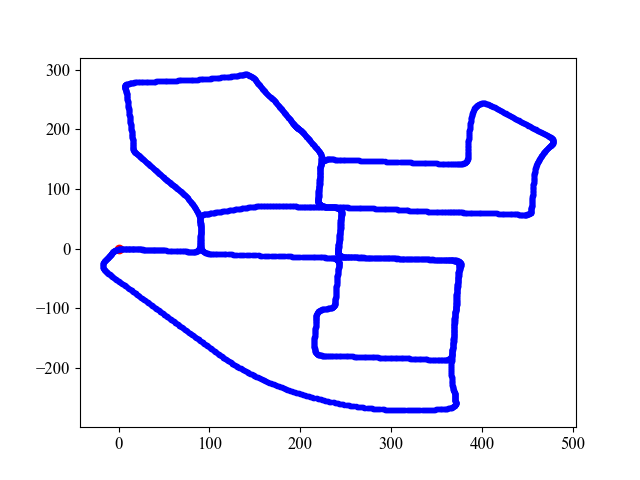

In [24]:
#plot trajectory
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(mat_full[0,2,3], mat_full[0,0,3], 'ro') #mark start in red
for i in range(frame):
    ax.plot(mat_full[i,2,3], mat_full[i,0,3], 'b.')

In [ ]:
#plot body frame velocity
v_xyz = np.diff(mat_full[:,:,3], axis = 0)
v_xyz = np.array([v_xyz[:,2], v_xyz[:,0], v_xyz[:,1] ]).T #need to reorder
# print(v_xyz[10])
vf = np.sqrt(v_xyz[:,0]**2  + v_xyz[:,1]**2)

fig, ax = plt.subplots()
ax.plot(vf)


## True transformation between frames (for mini KITTI datsets)


In [ ]:
#get true transformation between frames (for mini KITTI datsets)
from metpy.calc import lat_lon_grid_deltas
idx = 51
poses0 = dataset.oxts[idx] #<- ID of 1st scan
poses1 = dataset.oxts[idx+1] #<- ID of 2nd scan
lat0 = poses0.packet.lat
lon0 = poses0.packet.lon
alt0 = poses0.packet.alt
lat1 = poses1.packet.lat
lon1 = poses1.packet.lon
alt1 = poses1.packet.alt

# print(lat0)
# print(lon0)

dx_oxts, dy_oxts = lat_lon_grid_deltas(np.array([lon0,lon1]), np.array([lat0, lat1]))
# print(dx_oxts, dy_oxts) 
dx_oxts = dx_oxts[0,0].magnitude
dy_oxts = dy_oxts[0,0].magnitude
dz_oxts = (alt0-alt1)
droll_oxts = (poses0.packet.roll - poses1.packet.roll)
dpitch_oxts = (poses0.packet.pitch - poses1.packet.pitch)
dyaw_oxts = (poses0.packet.yaw - poses1.packet.yaw)

rot = poses1.T_w_imu[:3,:3] #trying this

dxyz_oxts = np.array([[dx_oxts, dy_oxts, dz_oxts]])
dxyz_lidar = dxyz_oxts.dot(rot)
print(dxyz_lidar)

dt = 0.10
# dt = 0.1037 #mean time between lidar samples
from_vel = np.array([[poses1.packet.vf*dt, poses1.packet.vl*dt, poses1.packet.vu*dt, -poses1.packet.wf*dt, -poses1.packet.wl*dt, -poses1.packet.wu*dt]])
print(from_vel)

# print(poses1.packet.vel_accuracy)
# print((dataset.timestamps[idx+1] - dataset.timestamps[idx]).microseconds/(10e5))

# # print(np.shape(dataset.timestamps)[0])
# # tvec = np.zeros(np.shape(dataset.timestamps)[0])
tvec = np.zeros(149)
# # for i in range(np.shape(dataset.timestamps)[0] - 1):
for i in range(149):
#     print((dataset.timestamps[i+1] - dataset.timestamps[i]).microseconds/(10e5))
    tvec[i] = (dataset.timestamps[i+1] - dataset.timestamps[i]).microseconds/(10e5)
# print(tvec)

# fig, ax = plt.subplots()
# ax.plot(tvec)

In [ ]:
test = np.array([[1,2,3,4]])
test = np.append(test,np.array([[0,2,3,4]]),axis = 0)
print(test)

In [ ]:
#test batch rotation matrix conversions
from utils import R_tf

print(R_tf(tf.Variable([[0., 0., 1.]])), "\n")

angs = tf.Variable([[0., 0., 1.], [0., 0., 1.]])
# angs = tf.Variable([[0., 0., 1.]])
print(angs)

rots = R_tf(angs) 
print(rots)


In [ ]:
#pad tensors to get them to the same length
#to fix bug in get_U_and_L()

t1 = tf.ones([3,8], tf.int32)
print(t1)
t2 = tf.ones([3,7], tf.int32)
print(t2)

bofa = tf.sets.intersection(t1, t2).values
print(bofa)

In [ ]:
#test- workaround for in place tensor operations
indices = tf.cast(tf.constant([1, 2, 3, 5]), tf.int32)[:,None]
print("indices", indices)
updates = tf.ones(tf.shape(indices))
print("updates", updates)
shape = tf.constant([7, 1])
print("shape", shape)

b = tf.scatter_nd(indices, updates, shape)
print(b)


In [ ]:
#test incramenting strings for file names
for a in range(10):
    test = "Scan%04d.mat" %(a+1000)
    test =  'E:/Ford/IJRR-Dataset-1-subset/SCANS/' + test
print(test)

## Plot results of ICET estimates on KITTI lidar point clouds vs GPS/INS baseline

In [ ]:
import matplotlib.pyplot as plt
%matplotlib notebook
font = {'fontname':'Times New Roman'}

#v8 is the best so far...
ICET_estimates = np.loadtxt("ICET_estimates_v8.txt")
# ICET_estimates = np.loadtxt("ICET_estimates_v10.txt")
# OXTS_baseline = np.loadtxt("OXTS_baseline_v10.txt")
# ICET_estimates = np.loadtxt("ICET_estimates_v13.txt")
# OXTS_baseline = np.loadtxt("OXTS_baseline_v13.txt")
# ICET_estimates = np.loadtxt("ICET_estimates_v18.txt")
OXTS_baseline = np.loadtxt("OXTS_baseline_v17.txt")
BC = np.loadtxt("Before_correction_v18.txt")

# vf_from_matlab = np.loadtxt("vf.txt")
# vf_from_matlab = np.append(vf_from_matlab, 0)
# # print(vf_from_matlab)
# OXTS_baseline[:,0] = vf_from_matlab

# OXTS_baseline = np.loadtxt("OXTS_baseline_gps.txt")

# OXTS_baseline[:,3:] = OXTS_baseline[:,3:]/0.1*0.1037
# OXTS_baseline = OXTS_baseline/0.1*0.1037
OXTS_baseline = (OXTS_baseline/0.1*0.1037 + OXTS_baseline)/2 #test

# ICET_estimates[:,0] = ICET_estimates[:,0]/tvec*0.1

#fix sign errors
ICET_estimates[:,1] = -ICET_estimates[:,1]
ICET_estimates[:,3:] = -ICET_estimates[:,3:]
BC[:,1] = -BC[:,1]
BC[:,3:] = -BC[:,3:]

style1 = 'b-'
style2 = 'r-'
style3 = 'b--'

fig, ax = plt.subplots(3,2, constrained_layout = True)
ax[0,0].plot(BC[:,0], style3, label = 'ICET- before', alpha = 0.3)
ax[0,0].plot(ICET_estimates[:,0], style1, label = 'ICET- after')
ax[0,0].plot(OXTS_baseline[:,0], style2, label = 'GPS/INS Baseline')
# ax[0,0].plot(np.sqrt(OXTS_baseline[:,0]**2 + OXTS_baseline[:,1]**2), style2, label = 'GPS/INS Baseline')
ax[0,0].set_title("change in x per frame", **font)
ax[0,0].set_ylabel("dx (m)", **font)
ax[0,0].legend(loc = 'best')
ax[0,0].set_xlabel("frame", **font)

ax[1,0].plot(BC[:,1], style3, alpha = 0.3)
ax[1,0].plot(ICET_estimates[:,1], style1, lw = 1)
ax[1,0].plot(-OXTS_baseline[:,1], style2, lw = 1)
# ax[1,0].plot(np.arange(n//2, np.shape(ICET_estimates)[0] - n//2 ), moving_avg(OXTS_baseline[:,1], n),  style2, lw = 1)
ax[1,0].set_title("change in y per frame", **font)
ax[1,0].set_ylabel("dy (m)", **font)
ax[1,0].set_xlabel("frame", **font)

ax[2,0].plot(BC[:,2], style3, alpha = 0.3)
ax[2,0].plot(ICET_estimates[:,2], style1, lw = 1)
ax[2,0].plot(OXTS_baseline[:,2], style2, lw = 1)
# ax[2,0].plot(np.arange(n//2, np.shape(ICET_estimates)[0] - n//2 ), moving_avg(OXTS_baseline[:,2], n),  style2, lw = 1)
ax[2,0].set_title("change in z per frame", **font)
ax[2,0].set_ylabel("dz (m)", **font)
ax[2,0].set_xlabel("frame", **font)

ax[0,1].plot(BC[:,3], style3, alpha = 0.3)
ax[0,1].plot(ICET_estimates[:,3], style1, lw = 1)
ax[0,1].plot(OXTS_baseline[:,3], style2, lw = 1)
ax[0,1].set_title("change in roll per frame", **font)
ax[0,1].set_ylabel("droll (rad)", **font)
ax[0,1].set_xlabel("frame", **font)

ax[1,1].plot(BC[:,4], style3, alpha = 0.3)
ax[1,1].plot(ICET_estimates[:,4], style1, lw = 1)
ax[1,1].plot(OXTS_baseline[:,4], style2, lw = 1)
ax[1,1].set_title("change in pitch per frame", **font)
ax[1,1].set_ylabel("dpitch (rad)", **font)
ax[1,1].set_xlabel("frame", **font)

ax[2,1].plot(BC[:,5], style3, alpha = 0.3)
ax[2,1].plot(ICET_estimates[:,5], style1, lw = 1)
ax[2,1].plot(OXTS_baseline[:,5], style2, lw = 1)
ax[2,1].set_title("change in yaw per frame", **font)
ax[2,1].set_ylabel("dyaw (rad)", **font)
ax[2,1].set_xlabel("frame", **font)

# fig.tight_layout(h_pad = 0.1)
plt.show()

In [ ]:
#plot error between ICET and absolute position
plt.rc('font',family='Times New Roman')
fig3, ax3 = plt.subplots(1,1)

# ICET_pred_stds = np.loadtxt("ICET_pred_stds_v8.txt")
ICET_pred_stds = np.loadtxt("ICET_pred_stds_v13.txt")

# ICET_pred_stds = (2*np.sqrt(ICET_pred_stds))**2
# ICET_pred_stds = np.sqrt(2*(ICET_pred_stds**2))


#which component to look at
# c = 3 #roll
# c = 4 #pitch
# c = 5 #yaw
c = 0 # x (forward movement)

diffx = OXTS_baseline[:,c] - ICET_estimates[:,c]
diffx_BC = OXTS_baseline[:,c] - BC[:,c]

# print(abs(diffx))
print("correlation coefficient \n", np.corrcoef(abs(diffx), ICET_pred_stds[:,0]))

#flip sign when looking at yaw
if c ==5:
    diffx = -diffx 
    
cum_err = np.zeros(np.shape(ICET_pred_stds))
cum_diffx = np.zeros(np.shape(diffx))
cum_diffx_BC = np.zeros(np.shape(diffx_BC))

for i in range(np.shape(ICET_pred_stds)[0]):
    cum_err[i,:] = np.sum(ICET_pred_stds[:i,:]**2, axis = 0)
    #add in baseline OXTS 1-sigma errors
#     cum_err[i,:] += np.sqrt(2)*np.array([0.05,0.05,0.1,0.0005,0.0005,0.001])**2
    cum_err[i,:] += np.sqrt(2)*np.array([0.08,0.08,0.1,0.0005,0.0005,0.001745])**2
    cum_err[i,:] = np.sqrt(cum_err[i,:]) 
    
for j in range(np.shape(diffx)[0]):
    cum_diffx[j] = np.sum(diffx[:j]) 
    cum_diffx_BC[j] = np.sum(diffx_BC[:j]) 

# # #old (error for each individual timestep)------------------------
# ax3.plot(diffx, label = 'GPS/INS - ICET (after bias reduction)')
# ax3.plot(diffx_BC, 'b--', label = 'GPS/INS - ICET (before bias reduction)', alpha = 0.3)
# ax3.fill_between(np.linspace(0,150,np.shape(ICET_pred_stds)[0]), -2*ICET_pred_stds[:,c], 2*ICET_pred_stds[:,c], 
#                  color = (0.5,0.5,0.5,0.4), label = 'ICET Predicted 2σ Error Bounds')
# #-------------------------------------------------------------------

# #new (accumulated differences in error)--------------------------
# ax3.plot(np.linspace(0,15,np.shape(ICET_pred_stds)[0]), cum_diffx_with_ground, label = 'GPS/INS - ICET')
ax3.plot(np.linspace(0,15,np.shape(ICET_pred_stds)[0]), cum_diffx, label = 'GPS/INS - ICET (after correction)')
ax3.plot(np.linspace(0,15,np.shape(ICET_pred_stds)[0]), cum_diffx_BC, 'b--', alpha = 0.3, label = 'GPS/INS - ICET (before correction)')
ax3.fill_between(np.linspace(0,15,np.shape(ICET_pred_stds)[0]), -2*cum_err[:,c], 2*cum_err[:,c], 
                 color = (0,0,1,0.2), label = 'Predicted 2σ Error Bounds')
# # --------------------------------------------------------------------

# ax3.legend(loc = 'lower left')
ax3.legend(loc = 'best')
ax3.set_title("Predicted vs Actual Error in x")
ax3.set_xlabel("time (s)", **font)
ax3.set_ylabel("GPS/INS Baseline x - Odometry Estimate x (m)", **font)
# ax3.set_title("Predicted vs Actual Error in yaw")
# ax3.set_xlabel("time (s)", **font)
# ax3.set_ylabel("GPS/INS Baseline yaw - Odometry Estimate yaw (rad)", **font)
# ax3.set_ylim(-0.032,0.045)
# ax3.set_ylim([-0.07,0.07])

In [ ]:
#test where points are inside spherical cell...
# print(it.cloud1_tensor_spherical)
maxtheta = tf.constant([[0.2],[0.7]])
maxr = tf.constant([[0.5],[2.]])

ans1 = tf.greater(it.cloud1_tensor_spherical[:,1], maxtheta)
# print(ans1)
ans2 = tf.less(it.cloud1_tensor_spherical[:,0], maxr)
# print(ans2)
combined = tf.Variable([ans1, ans2])
# print(combined)
ans3 = tf.math.reduce_all(combined, axis = 1)

print(ans3)

In [ ]:
#duplicate each element of an n*1 vector 3 times
t = tf.linspace(0,5,6)[:,None]
print(t)

test  = tf.tile(t, [3,1])
# print(test)
test2 = tf.reshape(tf.transpose(tf.reshape(test, [3,-1])), [-1,1])
print(test2)
test3 = tf.reshape(tf.transpose(tf.reshape(test, [3,-1])), [-1,3])
print(test3)

In [ ]:
#duplicate each element of an n*3 vector 3 times
t = tf.linspace(1,5,5)
t = tf.transpose(tf.Variable([t, 2*t, 3*t]))
print(t)

test  = tf.tile(t, [4,1])
# print(test)

test = tf.reshape(tf.transpose(test), [3, 4, -1])
# print(test)

test = tf.transpose(test, [2,1,0])
# print(test)

test = tf.reshape(test, [-1,3])
print(test)


## Run MC sim to compare performance estimation in "realistic" scenes with flat vs curved surfaces

In [ ]:
epochs = 20

c1_OG = np.loadtxt("scene2_scan1.txt", dtype = float) #thin cylinders
c2_OG = np.loadtxt("scene2_scan2.txt", dtype = float)
# c1_OG = np.loadtxt("scene3_scan1.txt", dtype = float) #rectangles
# c2_OG = np.loadtxt("scene3_scan2.txt", dtype = float)
# c1 = np.loadtxt("scene4_scan1.txt", dtype = float) #cylinders
# c2 = np.loadtxt("scene4_scan2.txt", dtype = float)

xvec = np.zeros([epochs, 6])
pred_stds = np.zeros([epochs, 6])

for i in range(epochs):
    print("\n -------------- Epoch", i, "--------------------")
    #add noise (if not generated when point clouds were created)
    c1 = c1_OG + 0.02*np.random.randn(np.shape(c1_OG)[0], 3)
    c2 = c2_OG + 0.02*np.random.randn(np.shape(c2_OG)[0], 3)  

    it = ICET(cloud1 = c1, cloud2 = c2, fid = 70, niter = 20, draw = False, group = 2, RM = True)
    xvec[i] = it.X
    pred_stds[i] = it.pred_stds


In [ ]:
mean_soln_err = np.array([-0.5, 0, 0, 0, 0, 0,]) - np.mean(xvec, axis = 0)

print("Smaller Clylindrical features, no occlusion, no outlier rejection, n=10:\n")
# print("Rectangular features, no occlusion, no outlier rejection, n=50:\n")

print("mean solution error: \n", mean_soln_err)
soln_std = np.std(xvec, axis = 0)
print("\n experimentally determined std: \n", soln_std)
mean_pred_std = np.mean(pred_stds, axis = 0)
print("\n predicted std: \n", mean_pred_std)


In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
nbins = 10
ax.hist(xvec[:,0], nbins)
# ax.set_title("Clylindrical features, no occlusion, no outlier rejection, n=50")

In [ ]:
#removing bad indices from tensor (used in test where we replace dz with dnn soln)

test = tf.random.normal([4,3])
print(test)

bad_idx = tf.constant([1,3])[None,:]
print(bad_idx)
all_idx = tf.cast(tf.linspace(0,tf.shape(test)[0].numpy()-1,tf.shape(test)[0].numpy()), tf.int32)[None,:]
print(all_idx)

good_idx = tf.sets.difference(all_idx, bad_idx).values
print(good_idx)
print(tf.gather(test, good_idx))

